In [1]:
#import des dépendances
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import ruptures as rpt
plt.style.use("seaborn-v0_8")

In [7]:

# 2) Chargement et prétraitement
#df_weekly = pd.read_csv('Steam_users_10min_last_week.csv', sep=';', encoding='utf-8')

# Convertir DateTime en datetime
#df_weekly['DateTime'] = pd.to_datetime(df_weekly['DateTime'])

# Trier par date (important)
#df_weekly = df_weekly.sort_values('DateTime')

# Définir DateTime comme index
#df_weekly = df_weekly.set_index('DateTime')

# Convertir Users en numérique (enlevant les virgules si nécessaire)
#df_weekly['Users'] = df_weekly['Users'].astype(str).str.replace(",", "").astype(float)

#df_weekly.head()
import os
print(os.getcwd())


/home/florian/TSM_AnsecData/projet_ansecdata/notebooks


In [12]:
# Chargement
#df_weekly = pd.read_csv('Steam_users_10min_last_week.csv', sep=';', encoding='utf-8')
#df_weekly['DateTime'] = pd.to_datetime(df_weekly['DateTime'])
#df_weekly = df_weekly.sort_values('DateTime').set_index('DateTime')
#df_weekly['Users'] = df_weekly['Users'].astype(str).str.replace(",", "").astype(float)
#df_weekly = df_weekly.drop(columns=['Average Users'])

def build_flexible_timeseries_views(df):
    """
    df : DataFrame avec index DateTime déjà trié et colonnes numériques (Users, etc.)
    
    Retourne :
      df_daily_global  : toute la série, resamplée à 1 jour
      df_hourly_view   : partie horaire (1h + 10min agrégé à 1h), sans daily
      df_10min_view    : uniquement la partie 10min, sans hourly ni daily
    """
    df = df.sort_index().copy()
    
    # 1) Calcul des deltas temporels en secondes
    dt_seconds = df.index.to_series().diff().dt.total_seconds()

    # 2) Identifier début de chaque segment par fréquence
    #    1 jour = 86400s, 1h = 3600s, 10min = 600s
    start_hour = None
    start_10 = None
    
    if (dt_seconds == 3600).any():
        start_hour = df.index[dt_seconds == 3600].min()
    if (dt_seconds == 600).any():
        start_10 = df.index[dt_seconds == 600].min()
    
    print("Début segment horaire (1h) :", start_hour)
    print("Début segment 10min        :", start_10)
    
    # --- 1) Vue globale : toute la série resamplée à 1 jour ---
    df_daily_global = df.resample("1D").mean()
    
    # --- 2) Vue horaire : sans la partie daily ---
    # On commence à partir du début de l'horaire si disponible
    if start_hour is not None:
        df_no_daily = df.loc[start_hour:].copy()
        
        # On resample tout ça à 1h :
        # - la partie déjà horaire restera à 1h
        # - la partie 10min sera agrégée à 1h (moyenne)
        df_hourly_view = df_no_daily.resample("1H").mean()
    else:
        df_hourly_view = None
        print("Aucun segment horaire (1h) détecté, df_hourly_view = None")
    
    # --- 3) Vue 10min : uniquement la partie haute résolution ---
    if start_10 is not None:
        df_10min_view = df.loc[start_10:].copy()
        # On sécurise : resample exactement à 10min + moyenne
        df_10min_view = df_10min_view.resample("10min").mean()
    else:
        df_10min_view = None
        print(" Aucun segment 10min détecté, df_10min_view = None")
    
    return df_daily_global, df_hourly_view, df_10min_view

df_weekly = pd.read_csv('../Data/OLD/Steam_users_10min_last_week.csv', sep=';')

df_weekly['DateTime'] = pd.to_datetime(df_weekly['DateTime'])
df_weekly = df_weekly.sort_values('DateTime').set_index('DateTime')

# Nettoyage Users (en cas de virgules pour les milliers)
df_weekly['Users'] = df_weekly['Users'].astype(str).str.replace(",", "").astype(float)

# Pipeline flexible
df_daily_global, df_hourly_view, df_10min_view = build_flexible_timeseries_views(df_weekly)

print("daily:", df_daily_global.shape)
print("hourly:", None if df_hourly_view is None else df_hourly_view.shape)
print("10min:", None if df_10min_view is None else df_10min_view.shape)

data1 = df_daily_global.copy()
data2 = df_hourly_view.copy()
data3 = df_10min_view.copy()

Début segment horaire (1h) : 2025-09-21 01:00:00
Début segment 10min        : 2025-10-14 14:10:00
daily: (7953, 3)
hourly: (734, 3)
10min: (1009, 3)


/tmp/ipykernel_4897/923022178.py:46: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hourly_view = df_no_daily.resample("1H").mean()


In [13]:
import pandas as pd

# df_weekly existe déjà, avec :
# - index = DateTime
# - colonne 'Users' en float

# 1) S'assurer que l'index est bien trié
df1 = data1.sort_index().copy()

# 2) Calculer les deltas temporels entre points
dt = df1.index.to_series().diff()
dt_seconds = dt.dt.total_seconds()

# 3) Trouver la fréquence la plus fréquente (mode)
most_common_freq_seconds = dt_seconds.mode()[0]
freq_timedelta = pd.to_timedelta(most_common_freq_seconds, unit="s")
print("Fréquence dominante pour globale:", freq_timedelta)

df2 = data2.sort_index().copy()

# 2) Calculer les deltas temporels entre points
dt = df2.index.to_series().diff()
dt_seconds = dt.dt.total_seconds()

# 3) Trouver la fréquence la plus fréquente (mode)
most_common_freq_seconds = dt_seconds.mode()[0]
freq_timedelta = pd.to_timedelta(most_common_freq_seconds, unit="s")
print("Fréquence dominante pour horaire:", freq_timedelta)

df3 = data3.sort_index().copy()

# 2) Calculer les deltas temporels entre points
dt = df3.index.to_series().diff()
dt_seconds = dt.dt.total_seconds()

# 3) Trouver la fréquence la plus fréquente (mode)
most_common_freq_seconds = dt_seconds.mode()[0]
freq_timedelta = pd.to_timedelta(most_common_freq_seconds, unit="s")
print("Fréquence dominante pour 10min:", freq_timedelta)





Fréquence dominante pour globale: 1 days 00:00:00
Fréquence dominante pour horaire: 0 days 01:00:00
Fréquence dominante pour 10min: 0 days 00:10:00


In [23]:
# Verif des valeurs manquantes/infinies 

print("NaN pour globale:", data1['Users'].isna().sum())
print("Inf pour globale:", np.isinf(data1['Users']).sum())
print("dtype pour globale:", data1['Users'].dtype)

print("NaN pour horaire:", data2['Users'].isna().sum())
print("Inf pour  horaire:", np.isinf(data2['Users']).sum())
print("dtype pour horaire:", data2['Users'].dtype)

print("NaN pour 10 min:", data3['Users'].isna().sum())
print("Inf pour 10 ,min:", np.isinf(data3['Users']).sum())
print("dtype pour 10 min:", data3['Users'].dtype)

NaN pour globale: 1210
Inf pour globale: 0
dtype pour globale: float64
NaN pour horaire: 0
Inf pour  horaire: 0
dtype pour horaire: float64
NaN pour 10 min: 0
Inf pour 10 ,min: 0
dtype pour 10 min: float64


In [24]:
# Nettoyage des Nan pour globale
data1clean = data1['Users'].astype(float)              
data1clean = data1clean.replace([np.inf, -np.inf], np.nan) # remplacer inf par NaN
data1clean = data1clean.dropna()     #retire les nan

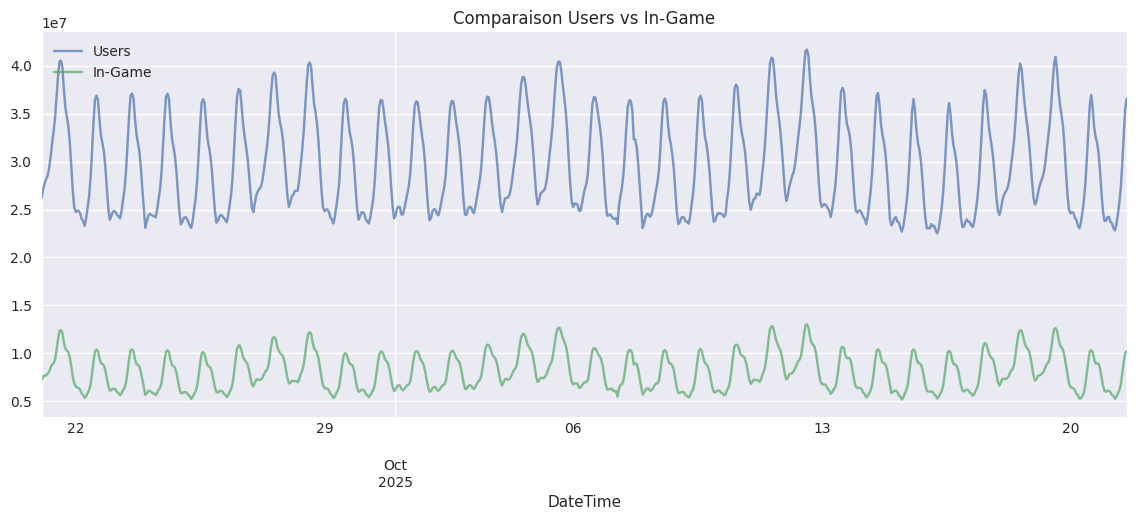

,Users,In-Game
Users,1.000000,0.975248
In-Game,0.975248,1.000000


In [27]:
# Vérification de la correlation entre users et in-game pour voir si on peut utiliser les deux features

data2[['Users', 'In-Game']].plot(figsize=(14,5), alpha=0.7)
plt.title("Comparaison Users vs In-Game")
plt.show()

data2[['Users', 'In-Game']].corr()

## Bon point : les deux feature sont fortement corrélées (0.975), on pourra donc utiliser in game pour les prédictions

In [31]:

adf_result = adfuller(data1clean)
print('ADF Statistic pour globale:', adf_result[0])
print('p-value pour globale:', adf_result[1])

adf_result = adfuller(data2['Users'])
print('ADF Statistic pour horaire:', adf_result[0])
print('p-value pour horaire:', adf_result[1])

adf_result = adfuller(data3['Users'])
print('ADF Statistic pour 10 min:', adf_result[0])
print('p-value pour 10 min:', adf_result[1])






ADF Statistic pour globale: -0.66582375685011
p-value pour globale: 0.8554044989900105
ADF Statistic pour horaire: -1.8190382813297812
p-value pour horaire: 0.3710515155333196
ADF Statistic pour 10 min: -6.562759810411337
p-value pour 10 min: 8.301864040150685e-09


# analyse : 
Série Daily : p-value très élevée (0.85) → aucune stationnarité, La série brute contient tendance + saison cachée, Après differencing cf ACF, une structure hebdomadaire apparaît ce qui confirme la non stationnarité

Série Horaire : p-value = 0.37 → toujours non stationnaire, cohérent avec ACF oscillante → saisonnalité journalière forte

Série 10 min : p-value < 1e-08 → stationnarité confirmée statistiquement, La résolution fine retire la tendance et fait apparaître un comportement plus stable, Indique que le signal est prévisible et exploitable à haute fréquence

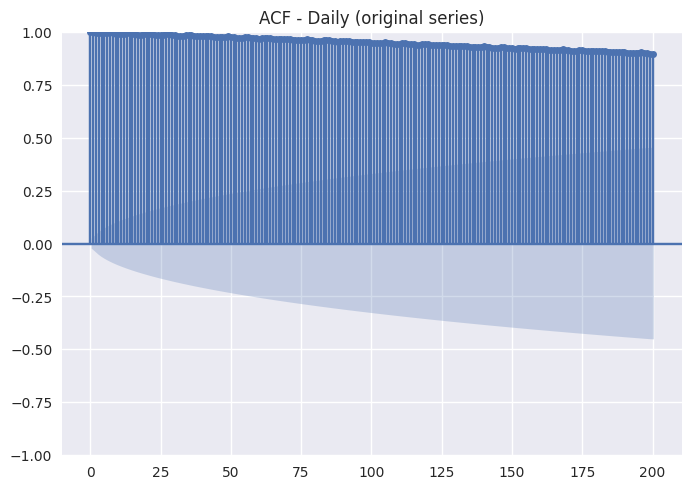

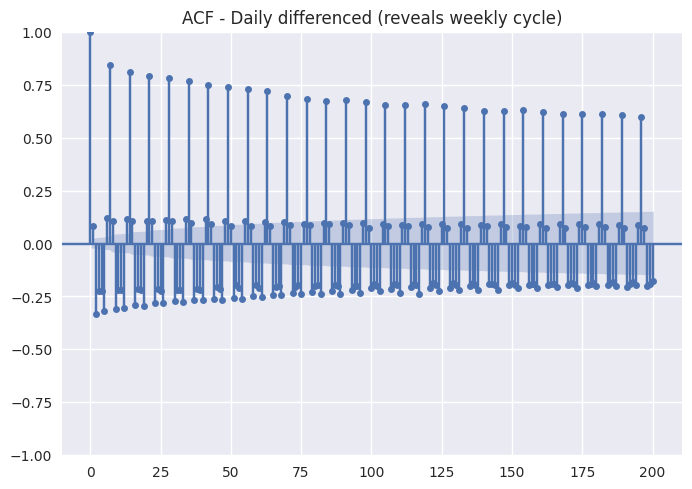

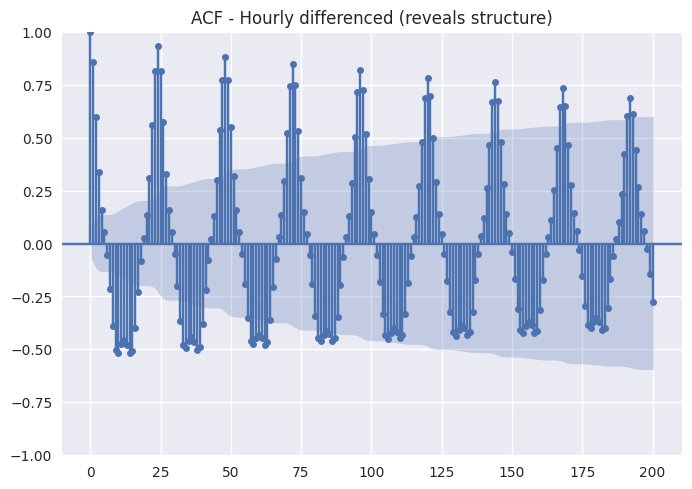

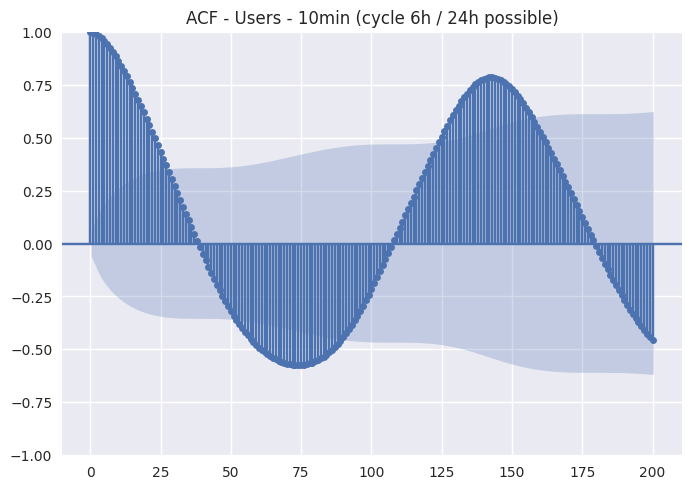

In [52]:
plot_acf(data1clean, lags=200)
plt.title("ACF - Daily (original series)")
plt.show()

daily_diff = data1clean.diff().dropna()

plot_acf(daily_diff, lags=200)
plt.title("ACF - Daily differenced (reveals weekly cycle)")
plt.show()

hourly_diff = data2['Users'].diff().dropna()

plot_acf(hourly_diff, lags=200)
plt.title("ACF - Hourly differenced (reveals structure)")
plt.show()


plot_acf(data3['Users'], lags=200)
plt.title("ACF - Users - 10min (cycle 6h / 24h possible)")
plt.show()




1) Vue quotidienne (série brute) : ACF presque plate donc aucune corrélation temporelle à priori, Pas de saisonnalité visible à cette granularité

2) Vue quotidienne différenciée : Forte autocorrélation, Alternance +/–, Pics réguliers à lag ~7, 14, 21, Présence d’une saisonnalité hebdomadaire nette et La série devient stationnaire après differencing, Une saisonnalité hebdomadaire existe, mais n’est révélée qu’après suppression de la tendance. La différenciation est nécessaire pour rendre la série stationnaire et modélisable.

3) Vue horaire (lag 24 = saisonnalité journalière) : Oscillation régulière, Pics importants à 24h, 48h, 72h,Décroissance lente : Forte saisonnalité journalière, Série non stationnaire mais structure riche. Le comportement utilisateur est rythmé par les cycles jour/nuit, probablement associé aux heures de disponibilité et d’activité des joueurs.

4) Vue 10 minutes (cycle 6h / 24h) : ACF sinusoïdale quasi parfaite, Très forte autocorrélation courte, Maximum à lag = 0, décroissance linéaire, Minimo vers lag ~75 (≈ 12–14h), Remontée ensuite → cycle complet ≈ 24h. Série stationnaire (confirmée par ADF) donc Modèle AR, SARIMA, LSTM ou Transformer extrêmement pertinent, Forte prédictibilité à haute fréquence : À haute résolution temporelle, la dynamique utilisateur est très régulière et prévisible, ce qui justifie l'utilisation de modèles avancés.

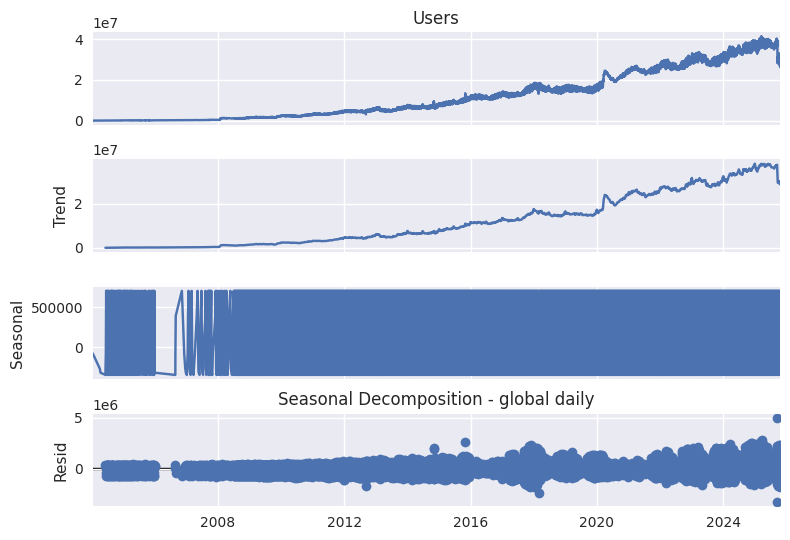

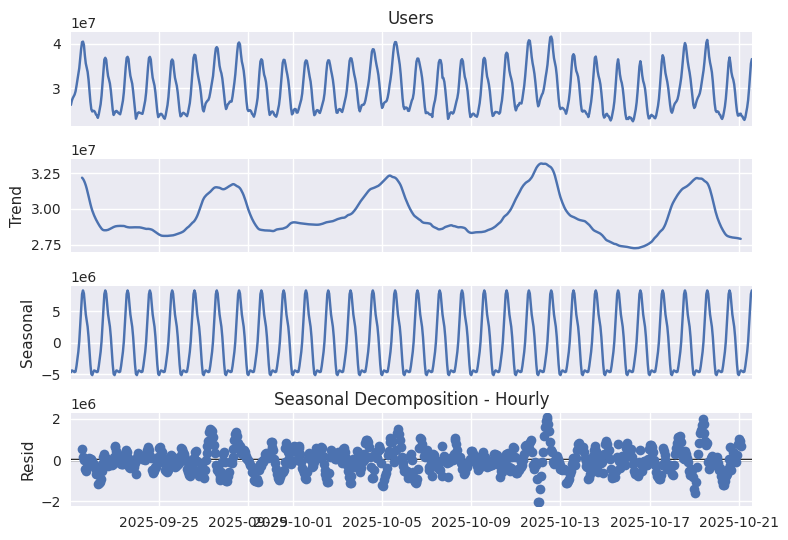

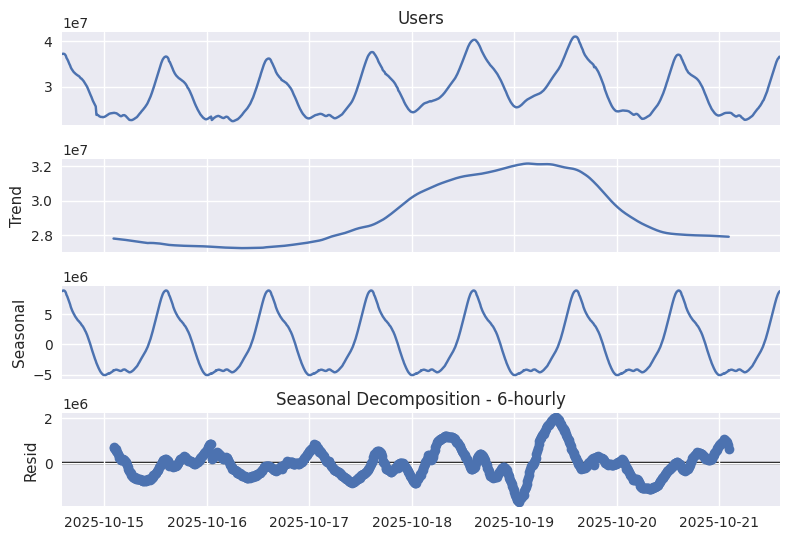

In [65]:
# Saisonnalités 
result = seasonal_decompose(data1clean, model='additive', period=7)
result.plot()
plt.title("Seasonal Decomposition - global daily")
plt.show()

result = seasonal_decompose(data2['Users'], model='additive', period=24)
result.plot()
plt.title("Seasonal Decomposition - Hourly")
plt.show()

result = seasonal_decompose(data3['Users'], model='additive', period=144)
result.plot()
plt.title("Seasonal Decomposition - 6-hourly")
plt.show()





Décomposition Daily (plusieurs années) : Trend très propre et cohérente (croissance structurelle de Steam sur 20 ans), Seasonal illisible → saturation visuelle → trop serré, Resid présente un élargissement progressif (variance croissante). Le modèle seasonal_decompose() n’est pas adapté aux séries très longues (>1000 points) car: assume que la saison est stable dans le temps et ne gère pas le changement structurel de variance. Pas vraiment exploitable dans l'état.


Décomposition Hourly : Trend cohérente : cycles jour/nuit visibles, Seasonal propre → sinus régulier sur 24h, Resid relativement stable avec quelques pics/anomalies. Montre clairement : le cycle circadien (activités de joueurs), structure stable pour ARIMA/SARIMA


 Décomposition 10 minutes : Trend lisse (comportement sur quelques jours seulement), Seasonal très propre : cycle journalier clair, Resid bruit blanc centré, mais variance un peu fluctuante. Meilleure granularité pour modèles ML (ex : LSTM / transformers).

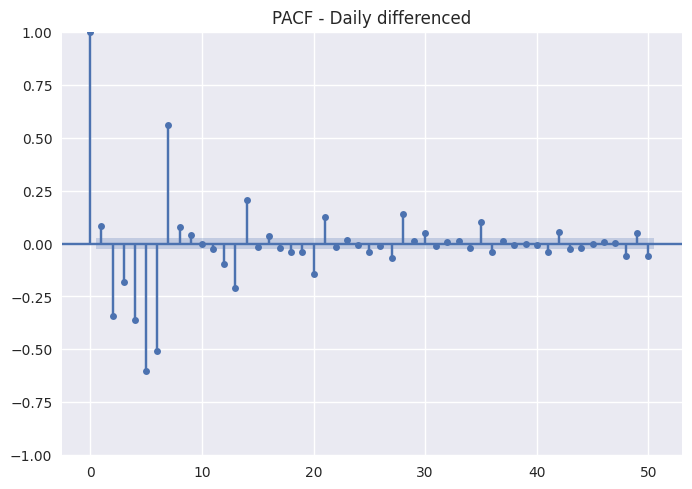

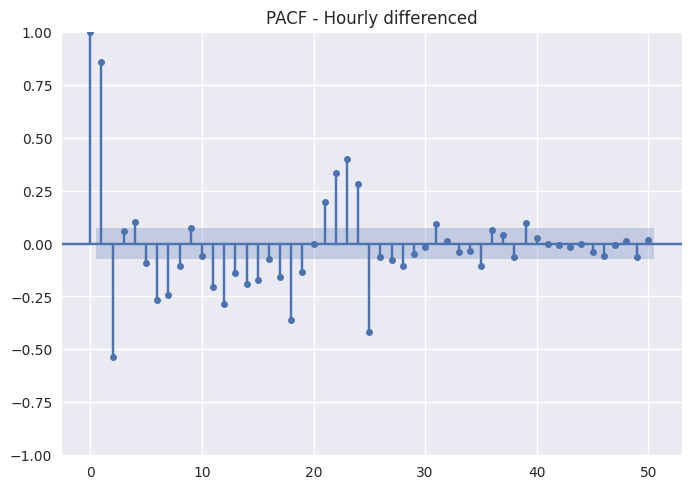

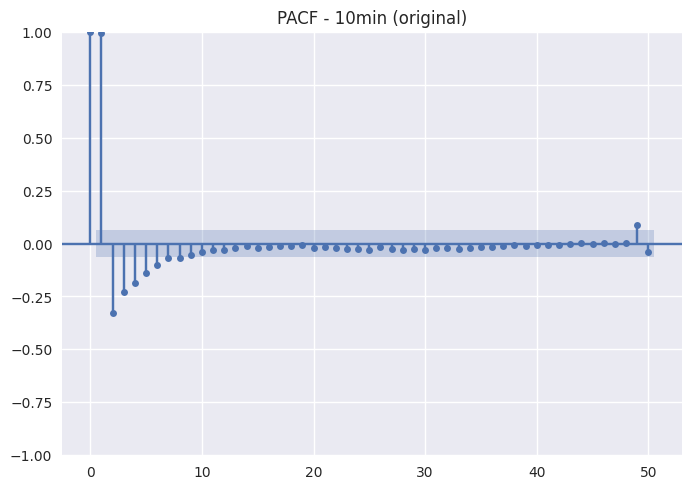

In [51]:
from statsmodels.graphics.tsaplots import plot_pacf

daily_diff = data1clean.diff().dropna()

plot_pacf(daily_diff, lags=50, method='ywm')
plt.title("PACF - Daily differenced")
plt.show()

hourly_diff = data2.diff().dropna()

hourly_diff = data2['Users'].diff().dropna()

plot_pacf(hourly_diff, lags=50, method='ywm')
plt.title("PACF - Hourly differenced")
plt.show()


plot_pacf(data3['Users'], lags=50, method='ywm')
plt.title("PACF - 10min (original)")
plt.show()

PACF – Daily differenced : Fort spike en lag 1, Un autre spike significatif en lag 7, Les autres lags sont petits et dans l’intervalle de confiance. Le modèle AR ne nécessite que un ou deux termes autoregressifs. La saisonnalité hebdomadaire (lag=7) reste clairement visible, La Structure AR simple mais saisonnière.

PACF – Hourly differenced : Très gros spikes en lag 1 et lag 2 donc AR(2) probable, Spikes significatifs récurrents autour de lag 24 (1 jour), 48, 72 → saisonnalité journalière très forte. Composante autoregressive locale forte, Cycle jour/nuit évident. 

PACF – 10min (stationnaire) : Spike fort à lag 1, Spike secondaire à lag 2, Chute rapide → plus rien de significatif au-delà donc Pas de saisonnalité longue évidente à cette échelle : Proche d’un processus AR(2) ou ARIMA(2,0,?). Très bonne stationnarité donc série prévisible localement : Modèle simple possible, mais aussi bon candidat pour LSTM / Transformers car structure fine

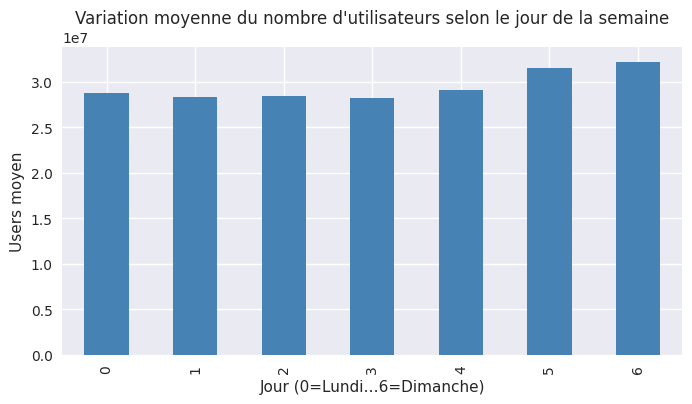

In [58]:
# Variation des users au cours de la semaine

data2['weekday'] = data2.index.weekday  # 0 = Lundi, 6 = Dimanche

plt.figure(figsize=(8,4))
data2.groupby('weekday')['Users'].mean().plot(kind='bar', color='steelblue')
plt.title("Variation moyenne du nombre d'utilisateurs selon le jour de la semaine")
plt.xlabel("Jour (0=Lundi…6=Dimanche)")
plt.ylabel("Users moyen")
plt.show()


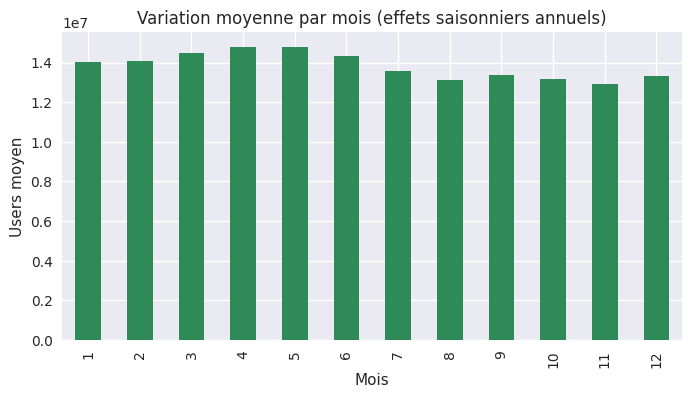

In [60]:
# Variation des users par mois
data1['month'] = data1.index.month

plt.figure(figsize=(8,4))
data1.groupby('month')['Users'].mean().plot(kind='bar', color='seagreen')
plt.title("Variation moyenne par mois (effets saisonniers annuels)")
plt.xlabel("Mois")
plt.ylabel("Users moyen")
plt.show()


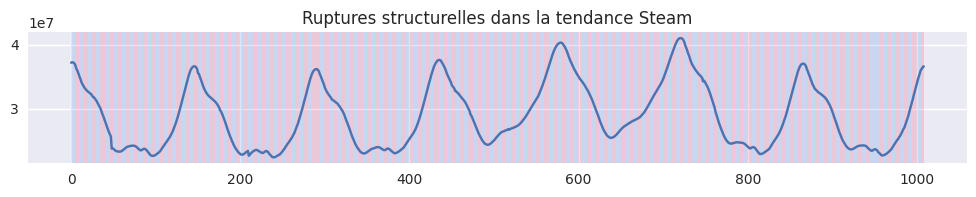

In [56]:
#Ruptues de tendances ou changepoints
signal = data3['Users'].values
model = "l2"
algo = rpt.Pelt(model=model).fit(signal)
breaks = algo.predict(pen=1e9)  # plus le pénalty est grand, moins il détecte de ruptures

rpt.display(signal, breaks)
plt.title("Ruptures structurelles dans la tendance Steam")
plt.show()
